Running simplified BB84 scenarios...

=== Scenario A: Alice <-> Bob (no Eve) ===
Total qubits: 20, Sifted bits: 13
Alice sifted key : [1 1 1 0 0 1 1 0 0 1 1 0 0]
Bob sifted key   : [1 1 1 0 0 1 1 0 0 1 1 0 0]
QBER: 0.00%

=== Scenario B: Intercept-Resend Eve ===
Total qubits: 20, Sifted bits: 11
Alice sifted key : [1 1 1 0 0 1 0 0 0 1 1]
Bob sifted key   : [0 1 0 1 0 1 0 0 0 1 1]
QBER: 27.27%
Note: Expected QBER ~25% for random intercept-resend (on average).
Session 1/12 - Eve: YES - QBER: 20.00%
Session 2/12 - Eve: YES - QBER: 35.00%
Session 3/12 - Eve: NO - QBER: 0.00%
Session 4/12 - Eve: NO - QBER: 0.00%
Session 5/12 - Eve: NO - QBER: 0.00%
Session 6/12 - Eve: NO - QBER: 0.00%
Session 7/12 - Eve: NO - QBER: 0.00%
Session 8/12 - Eve: YES - QBER: 35.00%
Session 9/12 - Eve: NO - QBER: 0.00%
Session 10/12 - Eve: NO - QBER: 0.00%
Session 11/12 - Eve: NO - QBER: 0.00%
Session 12/12 - Eve: NO - QBER: 0.00%

=== Delayed Detection Summary ===
QBER history (per session): ['20.00%', '35.00%', 

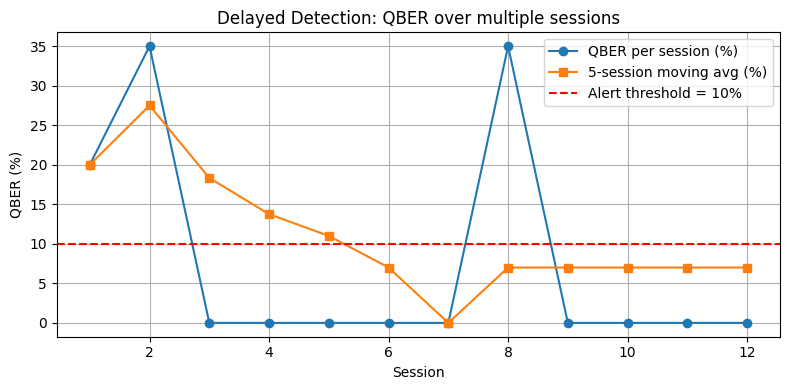


Done. Use results outA, outB, outC for further analysis or presentation.


In [4]:
"""
Simplified BB84 - 3 Scenarios (ready to run)
Scenarios:
 A) Alice <-> Bob (no Eve)
 B) Alice -> Eve (intercept-resend) -> Bob
 C) Delayed detection across multiple sessions (Bob delays measurement until Alice reveals bases)
"""
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator


SIM = Aer.get_backend("aer_simulator")

def prepare_and_run(alice_bits, alice_bases, bob_bases, seed=42):
    """Prepare circuit from Alice's bits/bases and Bob's bases; run and return Bob's measured bits."""
    n = len(alice_bits)
    qc = QuantumCircuit(n, n)
    # Alice prepares
    for i in range(n):
        if alice_bits[i] == 1:
            qc.x(i)
        if alice_bases[i] == 1:
            qc.h(i)
    qc.barrier()
    # Bob measures (apply H on qubit if measuring in X basis)
    for i in range(n):
        if bob_bases[i] == 1:
            qc.h(i)
        qc.measure(i, i)
    qc = transpile(qc, SIM)
    res = SIM.run(transpile(qc, SIM), shots=1).result()
    counts = res.get_counts()
    bitstr = list(counts.keys())[0]  # e.g. '0101...'
    # qiskit returns little-endian ordering: qubit 0 is rightmost bit, so reverse
    bitstr = bitstr[::-1]
    bob_bits = np.array([int(b) for b in bitstr])
    return bob_bits

def sift_and_qber(alice_bits, alice_bases, bob_bits, bob_bases):
    """Perform basis reconciliation (sifting) and compute QBER."""
    mask = (alice_bases == bob_bases)
    if mask.sum() == 0:
        return [], [], 0.0
    alice_sift = alice_bits[mask]
    bob_sift = bob_bits[mask]
    errors = np.sum(alice_sift != bob_sift)
    qber = errors / len(alice_sift)
    return alice_sift, bob_sift, qber

# ------------------------------
# Scenario A: No Eve
# ------------------------------
def scenario_no_eve(n_qubits=20, seed=101):
    rng = np.random.default_rng(seed)
    alice_bits = rng.integers(2, size=n_qubits)
    alice_bases = rng.integers(2, size=n_qubits)
    bob_bases = rng.integers(2, size=n_qubits)

    bob_bits = prepare_and_run(alice_bits, alice_bases, bob_bases, seed=seed+1)
    alice_sift, bob_sift, qber = sift_and_qber(alice_bits, alice_bases, bob_bits, bob_bases)

    print("\n=== Scenario A: Alice <-> Bob (no Eve) ===")
    print(f"Total qubits: {n_qubits}, Sifted bits: {len(alice_sift)}")
    print(f"Alice sifted key : {alice_sift}")
    print(f"Bob sifted key   : {bob_sift}")
    print(f"QBER: {qber*100:.2f}%")
    return {'alice_bits': alice_bits, 'alice_bases': alice_bases,
            'bob_bases': bob_bases, 'alice_sift': alice_sift, 'bob_sift': bob_sift, 'qber': qber}

# ------------------------------
# Scenario B: Intercept-Resend Eve
# ------------------------------
def scenario_with_eve(n_qubits=20, seed=202):
    rng = np.random.default_rng(seed)
    alice_bits = rng.integers(2, size=n_qubits)
    alice_bases = rng.integers(2, size=n_qubits)
    # Eve chooses random bases and measures (classical simulation)
    eve_bases = rng.integers(2, size=n_qubits)
    # Eve's measured bits: if Eve used same basis as Alice she gets the correct bit; else random
    eve_meas = np.empty(n_qubits, dtype=int)
    for i in range(n_qubits):
        if eve_bases[i] == alice_bases[i]:
            eve_meas[i] = alice_bits[i]
        else:
            eve_meas[i] = rng.integers(2)  # random outcome when wrong basis

    # Eve resends states prepared according to her measurement and her basis
    # So Bob receives states corresponding to (eve_meas, eve_bases)
    bob_bases = rng.integers(2, size=n_qubits)
    # Simulate Bob measuring the states Eve sent
    # We can reuse prepare_and_run by treating eve_meas/eve_bases as "alice" for this leg
    bob_bits = prepare_and_run(eve_meas, eve_bases, bob_bases, seed=seed+1)

    # Now sift compared to original Alice bits and bases (Alice and Bob publicly compare bases)
    alice_sift, bob_sift, qber = sift_and_qber(alice_bits, alice_bases, bob_bits, bob_bases)

    print("\n=== Scenario B: Intercept-Resend Eve ===")
    print(f"Total qubits: {n_qubits}, Sifted bits: {len(alice_sift)}")
    print(f"Alice sifted key : {alice_sift}")
    print(f"Bob sifted key   : {bob_sift}")
    print(f"QBER: {qber*100:.2f}%")
    print(f"Note: Expected QBER ~25% for random intercept-resend (on average).")
    return {'alice_bits': alice_bits, 'alice_bases': alice_bases,
            'eve_bases': eve_bases, 'eve_meas': eve_meas,
            'bob_bases': bob_bases, 'alice_sift': alice_sift, 'bob_sift': bob_sift, 'qber': qber}

# ------------------------------
# Scenario C: Delayed Detection (multiple sessions)
# ------------------------------
def scenario_delayed_detection(n_qubits=20, sessions=10, seed=303, eve_fraction=0.0):
    """
    Run multiple short BB84 sessions.
    eve_fraction = fraction of sessions where Eve intercepts (0.0 to 1.0)
    We simulate Bob delaying measurement: Bob measures only in Alice's basis (i.e., we measure in alice_bases)
    This simulates Bob storing and measuring after Alice reveals bases.
    """
    rng = np.random.default_rng(seed)
    qber_history = []

    for s in range(sessions):
        # decide whether this session has Eve
        eve_in_this_session = (rng.random() < eve_fraction)
        alice_bits = rng.integers(2, size=n_qubits)
        alice_bases = rng.integers(2, size=n_qubits)

        if not eve_in_this_session:
            # No Eve: Bob will measure in Alice's bases (delayed measurement)
            bob_bases = alice_bases.copy()
            bob_bits = prepare_and_run(alice_bits, alice_bases, bob_bases, seed=seed + s + 1)
        else:
            # Eve intercept-resend this session
            eve_bases = rng.integers(2, size=n_qubits)
            eve_meas = np.empty(n_qubits, dtype=int)
            for i in range(n_qubits):
                if eve_bases[i] == alice_bases[i]:
                    eve_meas[i] = alice_bits[i]
                else:
                    eve_meas[i] = rng.integers(2)
            # Bob measures after Alice reveals bases -> he measures in alice_bases
            bob_bases = alice_bases.copy()
            bob_bits = prepare_and_run(eve_meas, eve_bases, bob_bases, seed=seed + s + 1)

        _, _, qber = sift_and_qber(alice_bits, alice_bases, bob_bits, bob_bases)
        qber_history.append(qber)
        print(f"Session {s+1}/{sessions} - Eve: {'YES' if eve_in_this_session else 'NO'} - QBER: {qber*100:.2f}%")

    # Delayed detection policy: trigger if moving average over last K sessions exceeds threshold
    K = min(5, sessions)
    moving_avg = [np.mean(qber_history[max(0, i-K+1):i+1]) for i in range(len(qber_history))]
    alert_threshold = 0.10  # 10% moving-average threshold

    print("\n=== Delayed Detection Summary ===")
    print(f"QBER history (per session): {[f'{q*100:.2f}%' for q in qber_history]}")
    print(f"Moving average (window={K}): {[f'{m*100:.2f}%' for m in moving_avg]}")
    if any(m > alert_threshold for m in moving_avg):
        idx = next(i for i,m in enumerate(moving_avg) if m > alert_threshold)
        print(f"🚨 ALERT: Delayed detection triggered at session {idx+1} (moving avg {moving_avg[idx]*100:.2f}%)")
    else:
        print("✅ No delayed-detection alerts (QBER stable).")

    # Plot QBER history
    plt.figure(figsize=(8,4))
    plt.plot(range(1, sessions+1), np.array(qber_history)*100, marker='o', label='QBER per session (%)')
    plt.plot(range(1, sessions+1), np.array(moving_avg)*100, marker='s', label=f'{K}-session moving avg (%)')
    plt.axhline(alert_threshold*100, color='r', linestyle='--', label=f'Alert threshold = {alert_threshold*100:.0f}%')
    plt.xlabel('Session')
    plt.ylabel('QBER (%)')
    plt.title('Delayed Detection: QBER over multiple sessions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {'qber_history': qber_history, 'moving_avg': moving_avg}

# ------------------------------
# Run the three scenarios
# ------------------------------
if __name__ == "__main__":
    print("Running simplified BB84 scenarios...")

    # Scenario A: no Eve
    outA = scenario_no_eve(n_qubits=20, seed=1001)

    # Scenario B: intercept-resend Eve
    outB = scenario_with_eve(n_qubits=20, seed=2002)

    # Scenario C: delayed detection over multiple sessions:
    # We'll set eve_fraction to 0.3 (30% sessions include Eve) to demonstrate delayed detection
    outC = scenario_delayed_detection(n_qubits=20, sessions=12, seed=3003, eve_fraction=0.3)

    print("\nDone. Use results outA, outB, outC for further analysis or presentation.")
